In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as u
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet, CharmmPsfFile
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sbn

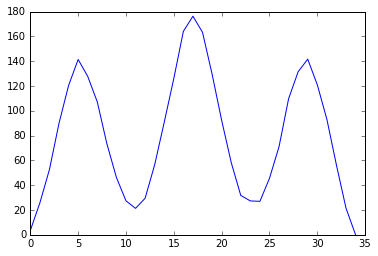

In [2]:
param = CharmmParameterSet('../../data/charmm_ff/top_all36_cgenff.rtf',
                           '../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../structure/butane.psf'
scan = '../torsion_scans/DFT_b3lyp/butane_scan_b3lyp_360.log'

butane_scan = ScanSet.parse_psi4(scan, structure)
butane_scan.compute_energy(param)

plt.plot(butane_scan.mm_energy)

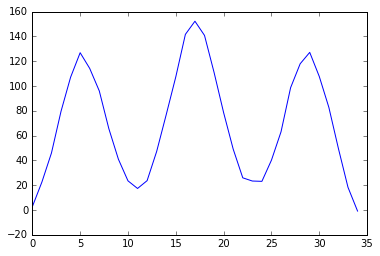

In [3]:
plt.plot(butane_scan.delta_energy)

In [4]:
# Create model (code is modified to set up qm_fit to this difference potential)
# Model and sample. The code was modified to fit the difference potential. 

platform = mm.Platform.getPlatformByName('Reference')

model = Model.TorsionFitModelEliminatePhase(param, butane_scan, platform=platform,
                                            param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')])

sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='diff_pot_mult_on.db', verbose=5)

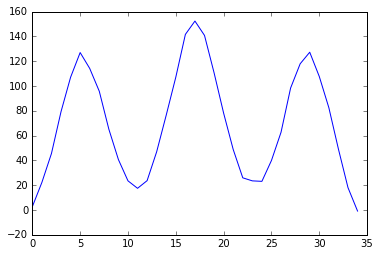

In [5]:
plt.plot(sampler.qm_fit.value)

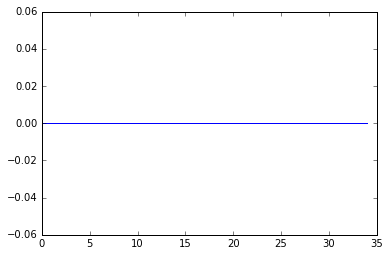

In [6]:
# Turn off all parameters

# Turn everything off
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0
param.dihedral_types[('HGA3', 'CG331', 'CG321', 'HGA2')][0].phi_k=0
param.dihedral_types[('HGA2', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param.dihedral_types[('HGA3', 'CG331', 'CG321', 'CG321')][0].phi_k=0
param.dihedral_types[('CG321', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param.dihedral_types[('HGA2', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param.bond_types[('CG331', 'CG321')].k=0
param.bond_types[('CG321', 'CG321')].k=0
param.bond_types[('CG331', 'HGA3')].k=0
param.bond_types[('CG321', 'HGA2')].k=0
param.urey_bradley_types[('CG331', 'CG321', 'CG321')].k  = 0
param.urey_bradley_types[('CG331', 'CG321', 'HGA2')].k = 0
param.urey_bradley_types[('CG321', 'CG321', 'HGA2')].k = 0
param.urey_bradley_types[('HGA3', 'CG331', 'CG321')].k = 0
param.urey_bradley_types[('HGA3', 'CG331', 'HGA3')].k = 0
param.urey_bradley_types[('HGA2', 'CG321', 'HGA2')].k = 0

param.angle_types[('CG331', 'CG321', 'CG321')].k  = 0
param.angle_types[('CG331', 'CG321', 'HGA2')].k = 0
param.angle_types[('CG321', 'CG321', 'HGA2')].k = 0
param.angle_types[('HGA3', 'CG331', 'CG321')].k = 0
param.angle_types[('HGA3', 'CG331', 'HGA3')].k = 0
param.angle_types[('HGA2', 'CG321', 'HGA2')].k = 0

# Turn off LJ
param.atom_types['CG331'].sigma_14 = 1.0
param.atom_types['CG331'].rmin = 1.0
param.atom_types['CG331'].rmin_14 = 1.0
param.atom_types['CG331'].epsilon_14 = 0
param.atom_types['CG331'].sigma=1.0
param.atom_types['CG331'].epsilon = 0.0
param.atom_types['CG321'].epsilon_14 = 0.0
param.atom_types['CG321'].rmin_14 = 1.0
param.atom_types['CG321'].sigma_14 = 1.0
param.atom_types['CG321'].sigma=1.0
param.atom_types['CG321'].epsilon = 0.0
param.atom_types['HGA3'].epsilon_14 = 0.0
param.atom_types['HGA3'].sigma = 1.0
param.atom_types['HGA3'].epsilon = 0.0
param.atom_types['HGA2'].epsilon_14 = 0.0
param.atom_types['HGA2'].sigma = 1.0
param.atom_types['HGA2'].epsilon = 0.0

# Turn off charge

for atom in butane_scan.structure.atoms:
    atom.charge = 0
    
# Reparameterize 
butane_scan.integrator = mm.VerletIntegrator(0.004*u.picoseconds)
butane_scan.create_context(param)
butane_scan.compute_energy(param)
plt.plot(butane_scan.mm_energy)

In [8]:
sampler.sample(10000)

Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic log_sigma
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
 [-----------------100%-----------------] 10001 of 10000 complete in 1758.8 sec

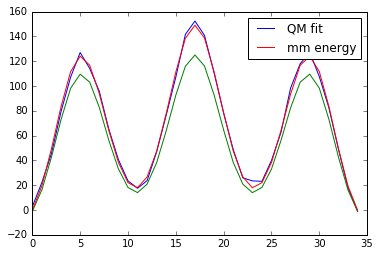

In [10]:
plt.plot(sampler.qm_fit.value, label='QM fit')
plt.plot(butane_scan.delta_energy)
plt.plot(butane_scan.mm_energy, label='mm energy')
plt.legend()

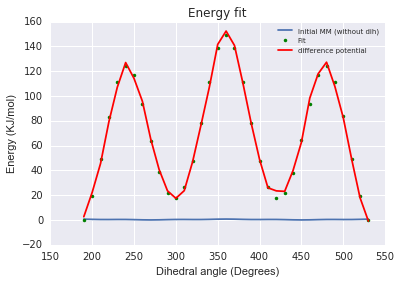

In [25]:
plt.plot(butane_scan.steps, sampler.trace('mm_energy')[0], label='Initial MM (without dih)')
plt.plot(butane_scan.steps, sampler.trace('mm_energy')[-1], '.', color='green', label='Fit')
plt.plot(butane_scan.steps, sampler.qm_fit.value, color='red', label='difference potential')
plt.legend(prop={'size': 7})
plt.title('Energy fit')
plt.xlabel('Dihedral angle (Degrees)')
plt.ylabel('Energy (KJ/mol)')
plt.savefig('Energy_fit_mult_on_diff.pdf')

In [12]:
import seaborn as sbn

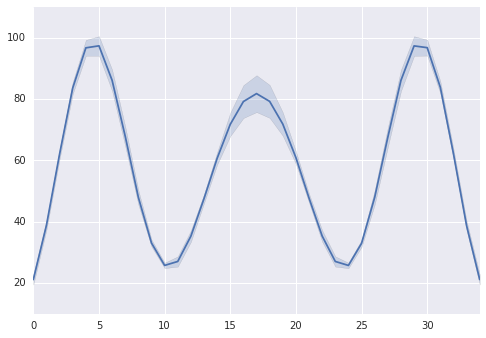

In [19]:
sbn.tsplot(sampler.trace('mm_energy')[:100])

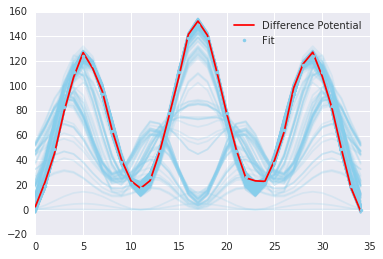

In [28]:
for i in range(1000):
    plt.plot(sampler.trace('mm_energy')[i], alpha=0.2, color='skyblue')
plt.plot(sampler.qm_fit.value, color='red', label='Difference Potential')
plt.plot(sampler.trace('mm_energy')[-1], '.', color='skyblue', label='Fit')
plt.legend()
plt.savefig('MM_distribution_mult_on.pdf')

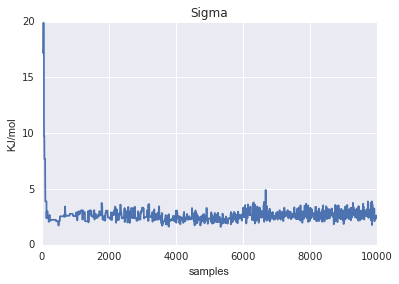

In [27]:
plt.plot(np.exp(sampler.trace('log_sigma')[:]), label='sigma')
plt.xlabel('samples')
plt.ylabel('KJ/mol')
plt.title('Sigma')
plt.savefig('sigma_mult_on_diff.pdf')

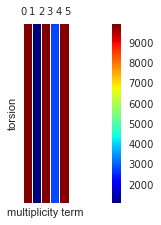

In [21]:
plots.marg_mult(model, sampler, 10000, 0, 'mult_diff.png')

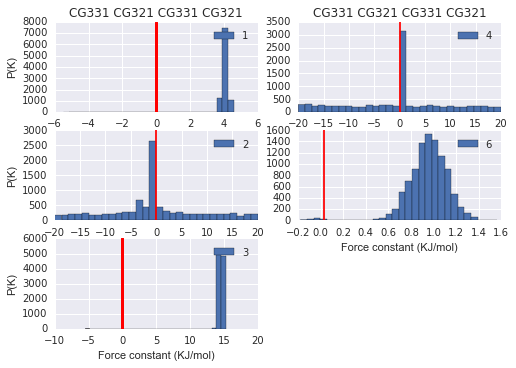

In [22]:
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 1)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:], bins=30, label='1')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 3)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[:], bins=30, label='2')
plt.axvline(0.038, color='r')
plt.legend()
plt.ylabel('P(K)')

plt.subplot(3, 2, 5)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[:], bins=30, label='3')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.xlabel('Force constant (KJ/mol)')

plt.subplot(3, 2, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:], bins=30, label='4')
plt.title("CG331 CG321 CG331 CG321")
plt.axvline(0, color='r')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:], bins=30, label='6')
plt.axvline(0.032, color='r')
plt.legend()
plt.xlabel('Force constant (KJ/mol)')

plt.savefig('parameter_hist_mult_on_diff.pdf')

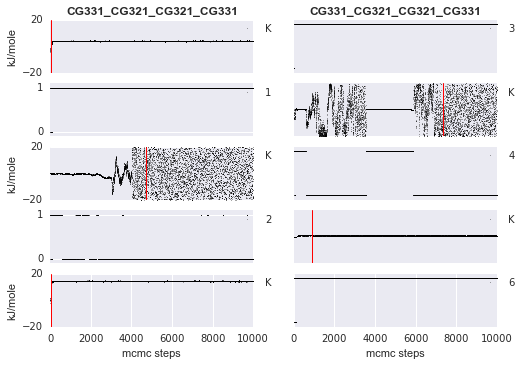

In [23]:
plots.trace_no_phase('CG331_CG321_CG321_CG331', sampler, markersize=1.0)

In [74]:
# Calculate full MM with the torsion parameters.
# Function to take parameters from traces and caclulate energies.

def parameterize_from_db(db, i=-1, param=None, mult_on=True, phase=False):
    """ This function parameterizes molecule with torsions from database"""
    
    # First figure out which torsions are turned on
    if mult_on:
        mult_bistring = {}
        for key in db.getstate()['stochastics']:
            key_split = key.split('_')
            if key_split[-1] == 'bitstring':
                tor_name = key_split[0] + '_' + key_split[1] + '_' + key_split[2] + '_' + key_split[3]
                mult_bistring[tor_name] = get_multiplicity_trace(key, db)
    
    # Now 
    return mult_bistring
    
def get_multiplicity_trace(key, db):
    multiplicities = (1, 2, 3, 4, 6)
    multiplicity_trace = {}
    for m in multiplicities:
        multiplicity_trace[str(m)] = []
        for i in db.trace(key)[:]:
            if 2**(m-1) & int(i):
                multiplicity_trace[str(m)].append(1)
            else:
                multiplicity_trace[str(m)].append(0)
    return multiplicity_trace
    

#plt.plot(sampler.BUTA1_offset.trace[:])

In [76]:
test = parameterize_from_db(db)

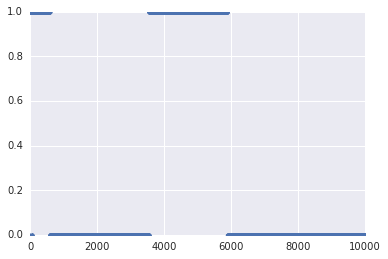

In [88]:
plt.plot(test['CG331_CG321_CG321_CG331']['4'], '.')

In [35]:
db = sqlite_plus.load('diff_pot_mult_on.db')

In [60]:
test = {}
for key in db.getstate()['stochastics']:
    i = key.split('_')
    if i[-1] == 'bitstring':
        name = i[0] + '_' + i[1] + '_' + i[2] + '_' + i[3]
        test[name] = getattr(db, key)[:]
    

In [61]:
test

{'CG331_CG321_CG321_CG331': array([ 34.,   4.,   4., ...,  53.,  53.,  53.])}

In [53]:
range(db.chains)[-1]

2

In [55]:
db.trace_names

[[u'BUTA1_offset',
  u'CG331_CG321_CG321_CG331_1_K',
  u'CG331_CG321_CG321_CG331_2_K',
  u'CG331_CG321_CG321_CG331_3_K',
  u'CG331_CG321_CG321_CG331_4_K',
  u'CG331_CG321_CG321_CG331_6_K',
  u'CG331_CG321_CG321_CG331_multiplicity_bitstring',
  u'DiscreteMetropolis_CG331_CG321_CG321_CG331_multiplicity_bitstring_adaptive_scale_factor',
  u'Metropolis_BUTA1_offset_adaptive_scale_factor',
  u'Metropolis_CG331_CG321_CG321_CG331_1_K_adaptive_scale_factor',
  u'Metropolis_CG331_CG321_CG321_CG331_2_K_adaptive_scale_factor',
  u'Metropolis_CG331_CG321_CG321_CG331_3_K_adaptive_scale_factor',
  u'Metropolis_CG331_CG321_CG321_CG331_4_K_adaptive_scale_factor',
  u'Metropolis_CG331_CG321_CG321_CG331_6_K_adaptive_scale_factor',
  u'Metropolis_log_sigma_adaptive_scale_factor',
  u'deviance',
  u'log_sigma',
  u'mm_energy',
  u'precision',
  u'sigma',
  u'state'],
 [u'BUTA1_offset',
  u'CG331_CG321_CG321_CG331_1_K',
  u'CG331_CG321_CG321_CG331_2_K',
  u'CG331_CG321_CG321_CG331_3_K',
  u'CG331_CG321_CG3